# **Introduction**
XGBoost model for ***Forecasting ML Models*** for stream temperature in **sub-basin # 31** of the Dairy McKay watershed. This code involves data reading, data processing, training, testing, and validation of the model.

Author: **Efrain Noa-Yarasca PhD**

# **I. XGBoost Regression model with Tunning**

In this page, the XGBoost model is trained and tested for stream temperatura prediction considering the sir-temperature (Ta), wind (Wind), solar radiation (SR), relative humisity (HR), the day in the year (DY), streamflow (Flow), precipitation (pp), and the shade factor (FS) as predictor variables. The daily stream temperature (Tw) is set as the only response variable.

Clean all variables

In [ ]:
### Reset variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

### **1. Read data**
Data in format CSV is read using the "read_csv" function

In [1]:
from pandas import read_csv
# Read DATA from 'stream_temp_and_predictors_SB31.csv'.
# FOLDER:     D:\research\ML_model\new_data\....
#data = read_csv('005_sb31_8v_no_norm_SF0_SFmax_2012_2017_for_train_test.csv', header=0, index_col=0)
#data = read_csv('005_sb59_8v_no_norm_SF0_SFmax.csv', header=0, index_col=0)
data = read_csv('002_sb31_no_norm_2012_2017_for_train_test.csv', header=0, index_col=0)
#data = read_csv('002_sb31_no_norm_only_2018_for_val.csv', header=0, index_col=0)
#data = read_csv('004_sb59_no_norm_2006_2011_for_train_test.csv', header=0, index_col=0)
#print (data.head())

### Select predictor and response variables
X = data.drop(['scenario', 'Tw'],axis=1) # For SB-31
#X = data.drop(['scenario', 'Tw_59'],axis=1) # For SB 59
y = data['Tw'] # y = data['Tw_59'] #
print ("Data dimension (X), (y):", X.shape, y.shape)

### Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Datasets dimension \n train_x, train_y, test_x, test_y: \n",
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Data dimension (X), (y): (6438, 8) (6438,)
Datasets dimension 
 train_x, train_y, test_x, test_y: 
 (4506, 8) (1932, 8) (4506,) (1932,)


### **2. Model definition and fit. Prediction and errors**


In [2]:
from xgboost import XGBRegressor

### XGBoost model based on best parameters from mannual tuning
print ("computing ........")
model_best_parm = XGBRegressor(
    alpha = 0.001,# alias "reg_alpha"
    booster = 'gbtree',
    colsample_bytree = 0.9,
    learning_rate = 0.01,
    max_depth = 8,
    n_estimators = 1500,
    objective = 'reg:squarederror',
    subsample = 1,#0.55,
    min_child_weight= 5, #1,
    gamma= 0.1, #0,
    seed=1
    )

### Fit the model and evaluation using train ans test
eval_set = [(train_x, train_y), (test_x, test_y)]
model_best_parm.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

### Prediction on train and test
pred_train = model_best_parm.predict(train_x) # prediction for 'Train' values
predict_test = model_best_parm.predict(test_x)

### RMSE and R2 on train and test using the model with best parameters
from sklearn.metrics import mean_squared_error, r2_score  ## use function score   RMSE

print("Train","RMSE: %.4f" % (mean_squared_error(train_y, model_best_parm.predict(train_x))**(1/2.0)))
print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, model_best_parm.predict(test_x))**(1/2.0)))
print ()

print("Train","R2: %.4f" % (model_best_parm.score(train_x, train_y))) # R2
print("Test", "R2: %.4f" % (model_best_parm.score(test_x, test_y)))   # R2


computing ........


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE: 0.2231
Test RMSE: 0.5260

Train R2: 0.9971
Test R2: 0.9841


### 3. Learning curve

# of epochs: 1500


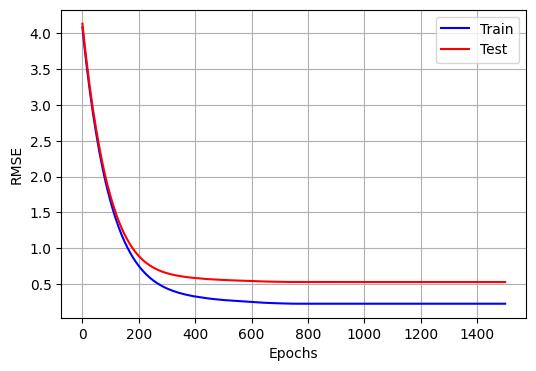

In [3]:
### Plot learning rate
import matplotlib.pyplot as plt
results = model_best_parm.evals_result() # Get rmse for validation 0 (train) & validatio 1 (test)

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
print ("# of epochs:", epochs)

fig = plt.figure(figsize=(6, 4))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train', color='blue')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.grid()
plt.show() #'''

from google.colab import files
fig.savefig('001_sb31_xgb_learning_curve.png', dpi=1024)
#files.download("001_sb31_xgb_learning_curve.png")

### **4. Importance of variables**

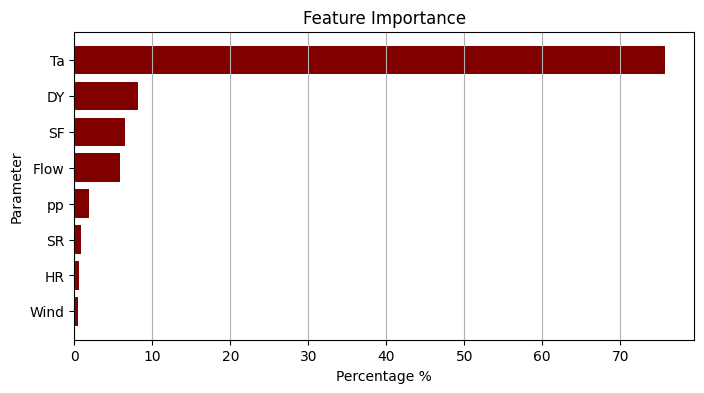

Importance in percentages: 
 [75.701416    8.196965    6.446921    5.884241    1.8702418   0.8178469
  0.5507773   0.53158844]


In [4]:
### Plot importance of parameters
import numpy as np
import matplotlib.pyplot as plt

f_importance = 100*model_best_parm.feature_importances_
sorted_idx = np.argsort(f_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), f_importance[sorted_idx], align='center',color ='maroon')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.grid(axis="x")
plt.xlabel("Percentage %")
plt.ylabel("Parameter")
plt.show()

print ("Importance in percentages: \n",f_importance[sorted_idx][::-1]) # Reversing the array to show values

#fig.savefig('002_sb31_xgb_feat_importance.png', dpi=1024)
#files.download("003_sb31_xgb_feat_importance.png")

In [ ]:
Ta, DY, SF, Flow, pp, SR, HR, Wind

### **Cost complexity prunning - Tree complexity penalty**
The tree complexity penalty compensates for the difference in the number of leaves in this case number of variables

In [5]:
from xgboost import XGBRegressor
model_bp = XGBRegressor(
    alpha = 0.001,# alias "reg_alpha"
    booster = 'gbtree',
    colsample_bytree = 0.9,
    learning_rate = 0.01,
    max_depth = 8,
    n_estimators = 1500,
    objective = 'reg:squarederror',
    subsample = 1,#0.55,
    min_child_weight= 5, #1,
    gamma= 0.1, #0,
    seed=1
    )

#### Train values

In [6]:
'''
st1 = sd[['Ta']]
st2 = sd[['Ta','Flow']]
st3 = sd[['Ta','Flow','DY']]
st4 = sd[['Ta','Flow','DY','SF']]
st5 = sd[['Ta','Flow','DY','SF','HR']]
st6 = sd[['Ta','Flow','DY','SF','HR','pp']]
st7 = sd[['Ta','Flow','DY','SF','HR','pp','SR']]
st8 = sd[['Ta','Flow','DY','SF','HR','pp','SR','Wind']] #'''

# Sets with 1-8 variables
'''
st1 = sd[['Ta']]
st2 = sd[['Ta','SR']]
st3 = sd[['Ta','SR','Wind']]
st4 = sd[['Ta','SR','Wind','pp']]
st5 = sd[['Ta','SR','Wind','pp','SF']]
st6 = sd[['Ta','SR','Wind','pp','SF','DY']]
st7 = sd[['Ta','SR','Wind','pp','SF','DY','HR']]
st8 = sd[['Ta','SR','Wind','pp','SF','DY','HR','Flow']] # '''

"\nst1 = sd[['Ta']]\nst2 = sd[['Ta','SR']]\nst3 = sd[['Ta','SR','Wind']]\nst4 = sd[['Ta','SR','Wind','pp']]\nst5 = sd[['Ta','SR','Wind','pp','SF']]\nst6 = sd[['Ta','SR','Wind','pp','SF','DY']]\nst7 = sd[['Ta','SR','Wind','pp','SF','DY','HR']]\nst8 = sd[['Ta','SR','Wind','pp','SF','DY','HR','Flow']] # "

In [7]:
### Sets of models
print("Predictor variables:",X.columns.values)
sd = train_x

# Sets with 1-8 variables
st1 = sd[['Ta']]
st2 = sd[['Ta','Flow']]
st3 = sd[['Ta','Flow','DY']]
st4 = sd[['Ta','Flow','DY','SF']]
st5 = sd[['Ta','Flow','DY','SF','HR']]
st6 = sd[['Ta','Flow','DY','SF','HR','pp']]
st7 = sd[['Ta','Flow','DY','SF','HR','pp','SR']]#'''
st8 = sd[['Ta','Flow','DY','SF','HR','pp','SR','Wind']]

sets = [st8]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

Predictor variables: ['Ta' 'Wind' 'SR' 'HR' 'DY' 'Flow' 'pp' 'SF']
Models to be tested:  ['M1']


Models to be tested:  ['M1']
Model M1 : ['Ta' 'Flow' 'DY' 'SF' 'HR' 'pp' 'SR' 'Wind']    ........  Done !
RMSE: [0.5310147205835457, 0.46403385893824683, 0.5989187439295629, 0.48920639177140735, 0.5201762817692058, 0.4997907055921246, 0.5161967694241038, 0.4894721831973097, 0.4800228742508511, 0.5456019038277456, 0.5203421311100388, 0.5216390557983158, 0.4900202959407316, 0.5150225342326629, 0.5266482387967607, 0.48575524434307493, 0.5034185360908908, 0.4926031442616276, 0.5186900097235035, 0.5868700857865192, 0.5457628566022964, 0.4663287344939058, 0.5348932589630331, 0.47797042306788984, 0.5090510777804222, 0.5357090947202782, 0.526084300820822, 0.5309982863725273, 0.5144105895820332, 0.508004806648665, 0.5240174878242445, 0.531241278395181, 0.4609385148406832, 0.5023155769500262, 0.5232307262215086, 0.5342441261146635, 0.4861457015549567, 0.5539320994917826, 0.5265904527486288, 0.4755360528923858, 0.4770936101465252, 0.5121528578747623, 0.5382295136319646, 0.523741588082157, 0.52975

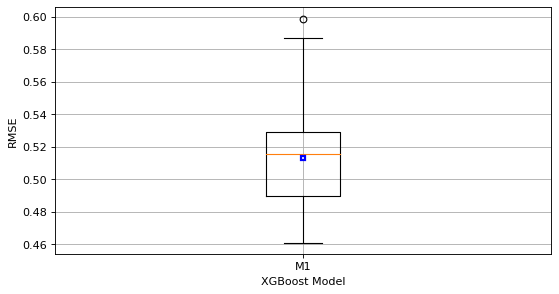

In [8]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

sets = [st1, st2, st3, st4, st5, st6, st7, st8]
sets = [st8]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

### Cross validation through all models defined above
scores_all_models = []
ccc = 0
for set_var in sets:
  ccc+=1
  print("Model M"+str(ccc),":",set_var.columns.values, "   ........" , end = ' ')
  n_repts = 5 #  <---------- SET
  cvr = RepeatedKFold(n_splits = 10, n_repeats = n_repts, random_state=2)
  #modelt = mbp #XGBRegressor() #LogisticRegression()
  scores = cross_val_score(model_bp, set_var, train_y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
  scores_p = [item * -1 for item in scores] # The previous line give Negative MSE
  #print ("Model M"+str(ccc),"   ........ Done !") #print (scores_p)
  print (" Done !") #print (scores_p)
  print ("RMSE:", scores_p)
  scores_all_models.append(scores_p)

### Get mean values of model's scores
from statistics import mean
#mean(scores_all_mods)
row_average = [sum(sub_list) / len(sub_list) for sub_list in scores_all_models]
print ("Mean values of RMSE for each tested model: \n",[round(n, 3) for n in row_average])
print ()

### Plot performance of all the models
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4), dpi=80)
plt.boxplot(scores_all_models, labels=sets_names, showmeans=1,
            meanprops={"marker":"s","markersize":"4","markerfacecolor":"white",
                       "markeredgecolor":"blue", "markeredgewidth":"2"})

plt.xlabel("XGBoost Model")
plt.ylabel("RMSE")
plt.grid()
plt.show()

In [ ]:
[1.497, 1.409, 1.149, 0.612, 0.511, 0.461, 0.42, 0.406]

#### Test values

In [ ]:
### Sets of models
print("Predictor variables:",X.columns.values)
sd = test_x

# Sets with 1-8 variables
st1 = sd[['Ta']]
st2 = sd[['Ta','SR']]
st3 = sd[['Ta','SR','Wind']]
st4 = sd[['Ta','SR','Wind','pp']]
st5 = sd[['Ta','SR','Wind','pp','SF']]
st6 = sd[['Ta','SR','Wind','pp','SF','DY']]
st7 = sd[['Ta','SR','Wind','pp','SF','DY','HR']]
st8 = sd[['Ta','SR','Wind','pp','SF','DY','HR','Flow']]

sets = [st1, st2, st3, st4, st5, st6, st7, st8]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

Predictor variables: ['Ta' 'Wind' 'SR' 'HR' 'DY' 'Flow' 'pp' 'SF']
Models to be tested:  ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']


Models to be tested:  ['M1']
Model M1 : ['Ta' 'SR' 'Wind' 'pp' 'SF' 'DY' 'HR' 'Flow']    ........  Done !
RMSE: [0.6167876870841819, 0.6290354683284466, 0.6512111597788467, 0.6406238793100019, 0.5893886289857297, 0.5757185229270233, 0.6271159985742721, 0.533243754261363, 0.589805485147777, 0.6611355450556019, 0.5994572571980742, 0.5134545129744164, 0.6034664497677292, 0.6381679619474115, 0.5995053495756195, 0.605867691241332, 0.6285816924188745, 0.65768226034491, 0.5783096455886578, 0.6372582343097534, 0.5843139552471985, 0.6831679124046518, 0.668093920150223, 0.5360714889302713, 0.5748529655771487, 0.6618467962152303, 0.5534431985613919, 0.6938405445289013, 0.6230671700660313, 0.5568555440833715, 0.6240005448580646, 0.5762983250872228, 0.6223808815717038, 0.6175274506795617, 0.5694649393275953, 0.6755026752491391, 0.6137210672021843, 0.6050575018924785, 0.5809688124460289, 0.6240490881137511, 0.5999889910506903, 0.6042295302277122, 0.6006447239408234, 0.6353835548694643, 0.59395382897

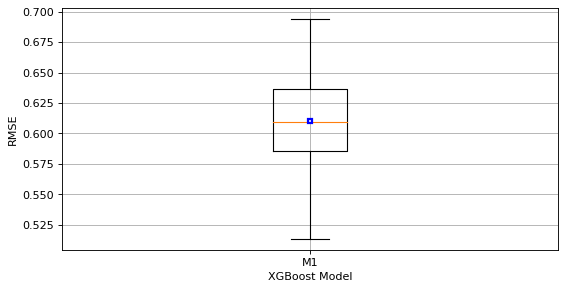

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

sets = [st1, st2, st3, st4, st5, st6, st7, st8]
sets = [st8]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

### Cross validation through all models defined above
scores_all_models = []
ccc = 0
for set_var in sets:
  ccc+=1
  print("Model M"+str(ccc),":",set_var.columns.values, "   ........" , end = ' ')
  n_repts = 5 #  <---------- SET
  cvr = RepeatedKFold(n_splits = 10, n_repeats = n_repts, random_state=2)
  #modelt = mbp #XGBRegressor() #LogisticRegression()
  scores = cross_val_score(model_bp, set_var, test_y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
  #scores = cross_val_score(model_bp, set_var, test_y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
  scores_p = [item * -1 for item in scores]
  #print ("Model M"+str(ccc),"   ........ Done !") #print (scores_p)
  print (" Done !") #print (scores_p)
  print ("RMSE:", scores_p)
  scores_all_models.append(scores_p)

### Get mean values of model's scores
from statistics import mean
#mean(scores_all_mods)
row_average = [sum(sub_list) / len(sub_list) for sub_list in scores_all_models]
print ("Mean values of RMSE for each tested model: \n",[round(n, 3) for n in row_average])
print ()

### Plot performance of all the models
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4), dpi=80)
plt.boxplot(scores_all_models, labels=sets_names, showmeans=1,
            meanprops={"marker":"s","markersize":"4","markerfacecolor":"white",
                       "markeredgecolor":"blue", "markeredgewidth":"2"})

plt.xlabel("XGBoost Model")
plt.ylabel("RMSE")
plt.grid()
plt.show()

### **CV for a group**

In [ ]:
### Sets of models
print("Predictor variables:",X.columns.values)
sd = test_x

# Sets with 2 variables
st_1 = sd[['Ta']]
st_2 = sd[['Ta', 'DY']]
st_3 = sd[['Ta', 'DY', 'SF']]
st_4 = sd[['Ta', 'DY', 'SF', 'Flow']]
st_5 = sd[['Ta', 'DY', 'SF', 'Flow', 'pp']]
st_6 = sd[['Ta', 'DY', 'SF', 'Flow', 'pp', 'SR']]
st_7 = sd[['Ta', 'DY', 'SF', 'Flow', 'pp', 'SR', 'HR']]
st_8 = sd[['Ta', 'DY', 'SF', 'Flow', 'pp', 'SR', 'HR', 'Wind']]
#Ta, DY, SF, Flow, pp, SR, HR, Wind

sets = [st_1, st_2, st_3, st_4, st_5, st_6, st_7, st_8]
sets = [st_8]

labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

Predictor variables: ['Ta' 'Wind' 'SR' 'HR' 'DY' 'Flow' 'pp' 'SF']
Models to be tested:  ['M1']


In [ ]:
from xgboost import XGBRegressor
model_bp = XGBRegressor(
    alpha = 0.001,# alias "reg_alpha"
    booster = 'gbtree',
    colsample_bytree = 0.9,
    learning_rate = 0.01,
    max_depth = 8,
    n_estimators = 1500,
    objective = 'reg:squarederror',
    subsample = 1,#0.55,
    min_child_weight= 5, #1,
    gamma= 0.1, #0,
    seed=1
    )


Models to be tested:  ['M1']
Model M1 : ['Ta' 'SR' 'Wind' 'pp' 'SF' 'DY' 'HR' 'Flow']    ........  Done !
MSE: [0.3804270509386546, 0.3956856204151882, 0.42407597462051055, 0.4103989547421958, 0.34737895597767815, 0.33145181764127346, 0.3932744756678065, 0.2843489014587528, 0.3478705103104045, 0.4371002089359678, 0.3593490032074381, 0.2636355368937951, 0.3641717559952673, 0.40725834765611296, 0.3594066641697858, 0.36707565929010205, 0.3951149440441765, 0.43254595557238995, 0.33444204618087897, 0.4060980571955845, 0.34142279829662514, 0.46671839653933006, 0.44634948614169245, 0.28737264124391804, 0.33045593203284257, 0.43804118166036465, 0.3062993740338643, 0.48141470123216223, 0.3882126984140928, 0.3100880969763877, 0.3893766799831614, 0.3321197594983383, 0.3873579617459712, 0.3813401523427985, 0.3242903171233818, 0.4563038642687438, 0.376653548327788, 0.3660945805963667, 0.33752476103494916, 0.3894372643756044, 0.35998678938202533, 0.3650933251992018, 0.36077408439794795, 0.4037122617

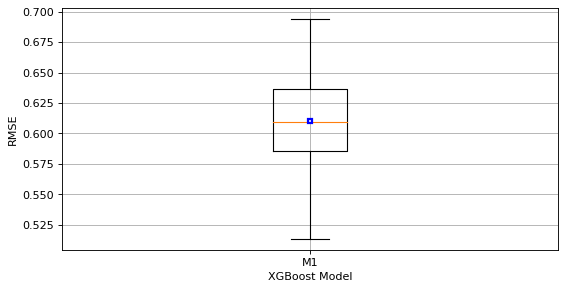

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

#sets = [st1, st2, st3, st4, st5, st6, st7, st8]
#sets = [st1, st2]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

### Cross validation through all models defined above
scores_all_models = []
scores_all_mse = []
ccc = 0
for set_var in sets:
  ccc+=1
  print("Model M"+str(ccc),":",set_var.columns.values, "   ........" , end = ' ')
  n_repts = 5 #  <---------- SET
  cvr = RepeatedKFold(n_splits = 10, n_repeats = n_repts, random_state=2)
  #modelt = mbp #XGBRegressor() #LogisticRegression()
  scores = cross_val_score(model_bp, set_var, test_y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
  scores_mse = cross_val_score(model_bp, set_var, test_y, scoring='neg_mean_squared_error', cv=cvr, n_jobs=-1)
  scores_p = [item * -1 for item in scores]
  scores_p_mse = [item * -1 for item in scores_mse]

  #print ("Model M"+str(ccc),"   ........ Done !") #print (scores_p)
  print (" Done !") #print (scores_p)
  print ("MSE:", scores_p_mse)
  print ("RMSE:", scores_p)
  scores_all_models.append(scores_p)
  scores_all_mse.append(scores_p_mse)

### Get mean values of model's scores
from statistics import mean
#mean(scores_all_mods)
row_average_mse = [sum(sub_list) / len(sub_list) for sub_list in scores_all_mse]
row_average = [sum(sub_list) / len(sub_list) for sub_list in scores_all_models]
print ("Mean values of MSE for each tested model: \n",[round(n, 3) for n in row_average_mse])
print ("Mean values of RMSE for each tested model: \n",[round(n, 3) for n in row_average])
print ()

### Plot performance of all the models
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4), dpi=80)
plt.boxplot(scores_all_models, labels=sets_names, showmeans=1,
            meanprops={"marker":"s","markersize":"4","markerfacecolor":"white",
                       "markeredgecolor":"blue", "markeredgewidth":"2"})

plt.xlabel("XGBoost Model")
plt.ylabel("RMSE")
plt.grid()
plt.show()

In [ ]:
### Save 'scores_all_models' as csv
import pandas as pd
from google.colab import files
df = pd.DataFrame(predict_test)
df.to_csv('pred.csv', encoding = 'utf-8-sig')
df = pd.DataFrame(test_y)
df.to_csv('test_y.csv', encoding = 'utf-8-sig')
#files.download('output.csv')

Models to be tested:  ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']
Model M1 : ['Ta']    ........  Done !
RMSE: [1.4382813340455263, 1.5844357435395875, 1.6565567839184534, 1.655928860207315, 1.5948936495314394, 1.5942641386050087, 1.586109292323739, 1.42134683917271, 1.533021460239387, 1.6269441871947488, 1.4410483228859365, 1.5793887211220188, 1.5555460257717135, 1.6219020583275974, 1.67272020338146, 1.6224270180805391, 1.6617353835288005, 1.5113427964145771, 1.3566276409090565, 1.6503543757361074, 1.6183765435957571, 1.5180611831077857, 1.6380784745822872, 1.4195388894412635, 1.607376857205895, 1.5950940571318812, 1.5849311432636866, 1.6917267384582921, 1.5491129674849562, 1.5178295663649877, 1.5661445096360973, 1.5147142360461125, 1.4870890282718894, 1.609171070625284, 1.50845205831188, 1.459081296918613, 1.6086564804691321, 1.700481317625172, 1.676187140240157, 1.57678835350111, 1.5505858296599506, 1.460244501249616, 1.609366357466086, 1.5363761997244119, 1.4129923421192108, 1.

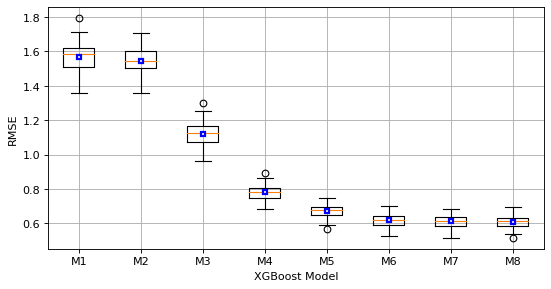

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

#sets = [st1, st2, st3, st4, st5, st6, st7, st8]
#sets = [st1, st2]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

### Cross validation through all models defined above
scores_all_models = []
ccc = 0
for set_var in sets:
  ccc+=1
  print("Model M"+str(ccc),":",set_var.columns.values, "   ........" , end = ' ')
  n_repts = 5 #  <---------- SET
  cvr = RepeatedKFold(n_splits = 10, n_repeats = n_repts, random_state=2)
  #modelt = mbp #XGBRegressor() #LogisticRegression()
  scores = cross_val_score(model_bp, set_var, test_y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
  scores_p = [item * -1 for item in scores]
  #print ("Model M"+str(ccc),"   ........ Done !") #print (scores_p)
  print (" Done !") #print (scores_p)
  print ("RMSE:", scores_p)
  scores_all_models.append(scores_p)

### Get mean values of model's scores
from statistics import mean
#mean(scores_all_mods)
row_average = [sum(sub_list) / len(sub_list) for sub_list in scores_all_models]
print ("Mean values of RMSE for each tested model: \n",[round(n, 3) for n in row_average])
print ()

### Plot performance of all the models
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4), dpi=80)
plt.boxplot(scores_all_models, labels=sets_names, showmeans=1,
            meanprops={"marker":"s","markersize":"4","markerfacecolor":"white",
                       "markeredgecolor":"blue", "markeredgewidth":"2"})

plt.xlabel("XGBoost Model")
plt.ylabel("RMSE")
plt.grid()
plt.show()

### **Search the optimal path**

In [ ]:
from pandas import read_csv
### Read DATA.
data = read_csv('002_sb31_no_norm_2012_2017_for_train_test.csv', header=0, index_col=0)
#data = read_csv('005_sb31_8v_no_norm_SF0_SFmax.csv', header=0, index_col=0)
#data = read_csv('005_sb59_8v_no_norm_SF0_SFmax_2006_2011_for_train_test.csv', header=0, index_col=0)
#data = read_csv('004_sb59_no_norm_2006_2011_for_train_test.csv', header=0, index_col=0)
#print (data.head())

### Select predictor and response variables
X = data.drop(['scenario', 'Tw'],axis=1) # For SB-31
#X = data.drop(['scenario', 'Tw_59'],axis=1) # For SB 59
y = data['Tw'] # y = data['Tw_59'] #
print ("Data dimension (X), (y):", X.shape, y.shape)

### Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Datasets dimension \n train_x, train_y, test_x, test_y: \n",
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Data dimension (X), (y): (6438, 8) (6438,)
Datasets dimension 
 train_x, train_y, test_x, test_y: 
 (4506, 8) (1932, 8) (4506,) (1932,)


In [ ]:
### Set the model with best parameters
from xgboost import XGBRegressor
model_bp = XGBRegressor(
    alpha = 0.001,# alias "reg_alpha"
    booster = 'gbtree',
    colsample_bytree = 0.9,
    learning_rate = 0.01,
    max_depth = 8,
    n_estimators = 1500,
    objective = 'reg:squarederror',
    subsample = 1,#0.55,
    min_child_weight= 5, #1,
    gamma= 0.1, #0,
    seed=1
    )

In [ ]:
### Get combination of children
def get_children (root, listvar2, sd):
  n_vars = 2
  c72 = list(itertools.combinations(listvar2,n_vars-1))
  print (len(c72))
  set_n = []
  sets = []
  for sid in c72:
    nnsid = root + list(sid)
    set_n.append(nnsid)
    st_d = sd[nnsid]
    sets.append(st_d)
  return set_n, sets

In [ ]:
### Get best path among children
def get_best_path (sets, model_bp, test_y):
  from sklearn.model_selection import RepeatedKFold
  from sklearn.model_selection import cross_val_score

  #sets = [st1, st2, st3, st4, st5, st6, st7, st8]
  #sets = [st1, st2]
  labels=[str(r) for r in sets]
  sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
  print("Models to be tested: ", sets_names)

  ### Cross validation through all models defined above
  scores_all_models = []
  ccc = 0
  for set_var in sets:
    ccc+=1
    print("Model M"+str(ccc),":",set_var.columns.values, "   ........" , end = ' ')
    n_repts = 5 #  <---------- SET
    cvr = RepeatedKFold(n_splits = 10, n_repeats = n_repts, random_state=2)
    #modelt = mbp #XGBRegressor() #LogisticRegression()
    scores = cross_val_score(model_bp, set_var, test_y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
    scores_p = [item * -1 for item in scores]
    #print ("Model M"+str(ccc),"   ........ Done !") #print (scores_p)
    print (" Done !") #print (scores_p)
    print ("RMSE:", scores_p)
    scores_all_models.append(scores_p)

  ### Get mean values of model's scores
  from statistics import mean
  #mean(scores_all_mods)
  row_average = [sum(sub_list) / len(sub_list) for sub_list in scores_all_models]
  print ("Mean values of RMSE for each tested model: \n",[round(n, 3) for n in row_average])
  print ()

  return row_average, scores_all_models

In [ ]:
### Main code to find best path and its scores
import itertools, copy, heapq

sd = test_x
# sd=1
root = ['Ta']
listvar = ['Flow', 'DY', 'SF','SR','pp','HR','Wind']
listvar2 = copy.deepcopy(listvar)

sam_all = [] #sam: score_all_models
bs_path = []
# Run the model with ONE variable ('Ta')
st_1 = [sd[['Ta']]]
row_average, sam = get_best_path(st_1, model_bp, test_y) # sam: score_all_models
sam_all.append(sam)
bs_path.append(min(row_average))

# Run the model for more then ONE variable
for i in range(7):
  print ("Searching level:__", i+1)

  #print (dasdsa)
  set_n, sets = get_children(root, listvar2, sd) # ------> Function
  print ("n_models:", set_n)

  row_average, sam = get_best_path(sets, model_bp, test_y) # ---------------> Function

  #row_average = [1.495, 1.381, 1.348, 1.533, 1.496, 1.563, 1.5]
  minpos = row_average.index(min(row_average))
  bs_path.append(min(row_average))
  best_child = set_n[minpos][-1] # get best child
  print ("best child:", set_n[minpos][-1])

  #min2 = heapq.nsmallest(2, row_average)[-1] # Get the second min
  #ind_min2 = row_average.index(min2) # SF

  # Get new root and left-list
  root.append(best_child)
  listvar2.remove(best_child)
  print (root)
  print (listvar2)
  sam_all.append(sam)
  print ()

print ("best path: ",root)
print (bs_path)
#'''

Models to be tested:  ['M1']
Model M1 : ['Ta']    ........  Done !
RMSE: [1.4382813340455263, 1.5844357435395875, 1.6565567839184534, 1.655928860207315, 1.5948936495314394, 1.5942641386050087, 1.586109292323739, 1.42134683917271, 1.533021460239387, 1.6269441871947488, 1.4410483228859365, 1.5793887211220188, 1.5555460257717135, 1.6219020583275974, 1.67272020338146, 1.6224270180805391, 1.6617353835288005, 1.5113427964145771, 1.3566276409090565, 1.6503543757361074, 1.6183765435957571, 1.5180611831077857, 1.6380784745822872, 1.4195388894412635, 1.607376857205895, 1.5950940571318812, 1.5849311432636866, 1.6917267384582921, 1.5491129674849562, 1.5178295663649877, 1.5661445096360973, 1.5147142360461125, 1.4870890282718894, 1.609171070625284, 1.50845205831188, 1.459081296918613, 1.6086564804691321, 1.700481317625172, 1.676187140240157, 1.57678835350111, 1.5505858296599506, 1.460244501249616, 1.609366357466086, 1.5363761997244119, 1.4129923421192108, 1.4812145357789022, 1.793769137172175, 1.588

#### Set by For loop

In [ ]:
from pandas import read_csv
### Read DATA.
data = read_csv('002_sb31_no_norm_2012_2017_for_train_test.csv', header=0, index_col=0)
#data = read_csv('005_sb31_8v_no_norm_SF0_SFmax.csv', header=0, index_col=0)
#data = read_csv('005_sb59_8v_no_norm_SF0_SFmax_2006_2011_for_train_test.csv', header=0, index_col=0)
#data = read_csv('004_sb59_no_norm_2006_2011_for_train_test.csv', header=0, index_col=0)
#print (data.head())

### Select predictor and response variables
X = data.drop(['scenario', 'Tw'],axis=1) # For SB-31
#X = data.drop(['scenario', 'Tw_59'],axis=1) # For SB 59
y = data['Tw'] # y = data['Tw_59'] #
print ("Data dimension (X), (y):", X.shape, y.shape)

### Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Datasets dimension \n train_x, train_y, test_x, test_y: \n",
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Data dimension (X), (y): (6438, 8) (6438,)
Datasets dimension 
 train_x, train_y, test_x, test_y: 
 (4506, 8) (1932, 8) (4506,) (1932,)


In [ ]:
# Set group of variables with n variables
import itertools
sd = test_x
listvar = ['Flow', 'DY', 'SF','SR','pp','HR','Wind']
n_vars = 5  # <-----------------   SET Number of Variables

c72 = list(itertools.combinations(listvar,n_vars-1))
print (len(c72))
set_n = []
sets = []
for sid in c72:
  nnsid = ['Ta'] + list(sid)
  set_n.append(nnsid)
  st_d = sd[nnsid]
  sets.append(st_d)

print ("n_models:", set_n)
#print (sets[0])

### Save models as csv
import pandas as pd
from google.colab import files
df_n = pd.DataFrame(set_n)
df_n.to_csv('model_names.csv', encoding = 'utf-8-sig')

35
n_models: [['Ta', 'Flow', 'DY', 'SF', 'SR'], ['Ta', 'Flow', 'DY', 'SF', 'pp'], ['Ta', 'Flow', 'DY', 'SF', 'HR'], ['Ta', 'Flow', 'DY', 'SF', 'Wind'], ['Ta', 'Flow', 'DY', 'SR', 'pp'], ['Ta', 'Flow', 'DY', 'SR', 'HR'], ['Ta', 'Flow', 'DY', 'SR', 'Wind'], ['Ta', 'Flow', 'DY', 'pp', 'HR'], ['Ta', 'Flow', 'DY', 'pp', 'Wind'], ['Ta', 'Flow', 'DY', 'HR', 'Wind'], ['Ta', 'Flow', 'SF', 'SR', 'pp'], ['Ta', 'Flow', 'SF', 'SR', 'HR'], ['Ta', 'Flow', 'SF', 'SR', 'Wind'], ['Ta', 'Flow', 'SF', 'pp', 'HR'], ['Ta', 'Flow', 'SF', 'pp', 'Wind'], ['Ta', 'Flow', 'SF', 'HR', 'Wind'], ['Ta', 'Flow', 'SR', 'pp', 'HR'], ['Ta', 'Flow', 'SR', 'pp', 'Wind'], ['Ta', 'Flow', 'SR', 'HR', 'Wind'], ['Ta', 'Flow', 'pp', 'HR', 'Wind'], ['Ta', 'DY', 'SF', 'SR', 'pp'], ['Ta', 'DY', 'SF', 'SR', 'HR'], ['Ta', 'DY', 'SF', 'SR', 'Wind'], ['Ta', 'DY', 'SF', 'pp', 'HR'], ['Ta', 'DY', 'SF', 'pp', 'Wind'], ['Ta', 'DY', 'SF', 'HR', 'Wind'], ['Ta', 'DY', 'SR', 'pp', 'HR'], ['Ta', 'DY', 'SR', 'pp', 'Wind'], ['Ta', 'DY', 'SR', 'HR

In [ ]:
### Sets of models

sets = sets # Defined above. [st1, st2, st3, st4, st5, st6, st7, st8]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

Models to be tested:  ['M1']


Models to be tested:  ['M1']
Model M1 : ['Ta' 'Flow' 'DY' 'SF' 'SR' 'pp' 'HR' 'Wind']    ........  Done !
RMSE: [0.8743383949375918, 0.7667626779615074, 0.8278188308236231, 0.8029736665759931, 0.8180329385807069, 0.8025054884803903, 0.8164887248298921, 0.7705883532970549, 0.8533189917118152, 0.790816138475708, 0.7405701271224808, 0.8551267239582914, 0.7910489528917904, 0.8931741529785002, 0.8264721074075054, 0.9639489267237825, 0.7324847860805337, 0.8810694239364678, 0.7169245538947362, 0.7696018286050035, 1.0175372973334984, 0.8504728220615081, 0.8471569231044284, 0.7903467863391193, 0.700905204827586, 0.715510724536341, 0.787763694982681, 0.7857335879218659, 0.83705806244113, 0.8031835096500245, 0.9241895744176812, 0.7559421894327726, 0.6813173613633742, 0.8658920172272213, 0.698203865272899, 0.8184876924138602, 0.7659719230894328, 0.8439106909832769, 0.8209701622077928, 0.833724099778274, 0.8306530201174748, 0.8490265834409463, 0.7737492052558604, 0.7637637833331965, 0.7320343280137

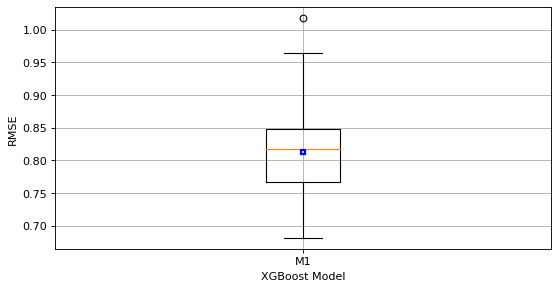

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

#sets = [st1, st2, st3, st4, st5, st6, st7, st8]
#sets = [st1, st2]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

### Cross validation through all models defined above
scores_all_models = []
ccc = 0
for set_var in sets:
  ccc+=1
  print("Model M"+str(ccc),":",set_var.columns.values, "   ........" , end = ' ')
  n_repts = 5 #  <---------- SET
  cvr = RepeatedKFold(n_splits = 10, n_repeats = n_repts, random_state=2)
  #modelt = mbp #XGBRegressor() #LogisticRegression()
  scores = cross_val_score(model_bp, set_var, test_y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
  scores_p = [item * -1 for item in scores]
  #print ("Model M"+str(ccc),"   ........ Done !") #print (scores_p)
  print (" Done !") #print (scores_p)
  print ("RMSE:", scores_p)
  scores_all_models.append(scores_p)

### Get mean values of model's scores
from statistics import mean
#mean(scores_all_mods)
row_average = [sum(sub_list) / len(sub_list) for sub_list in scores_all_models]
print ("Mean values of RMSE for each tested model: \n",[round(n, 3) for n in row_average])
print ()

### Plot performance of all the models
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4), dpi=80)
plt.boxplot(scores_all_models, labels=sets_names, showmeans=1,
            meanprops={"marker":"s","markersize":"4","markerfacecolor":"white",
                       "markeredgecolor":"blue", "markeredgewidth":"2"})

plt.xlabel("XGBoost Model")
plt.ylabel("RMSE")
plt.grid()
plt.show()

In [ ]:
scores_all_models

### Save csv file

In [ ]:
### Save 'scores_all_models' as csv
import pandas as pd
from google.colab import files
df = pd.DataFrame(scores_all_models)
df.to_csv('output.csv', encoding = 'utf-8-sig')
#files.download('output.csv')


### **5. Repeated Cross Validation for the model w/best parameters**

Cross validation GIVEN a list of sets of predictors

In [ ]:
### Sets of models
print("Predictor variables:",X.columns.values)

# Sets with 1-8 variables
st1 = X[['Ta']]
st2 = X[['Ta','SR']]
st3 = X[['Ta','SR','Wind']]
st4 = X[['Ta','SR','Wind','pp']]
st5 = X[['Ta','SR','Wind','pp','SF']]
st6 = X[['Ta','SR','Wind','pp','SF','DY']]
st7 = X[['Ta','SR','Wind','pp','SF','DY','HR']]
st8 = X[['Ta','SR','Wind','pp','SF','DY','HR','Flow']]

#sets = [st_1, st_2, st_3, st_4, st_5, st_6, st_7]
sets = [st1, st2, st3, st4, st5, st6, st7, st8]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

Predictor variables: ['Ta' 'Wind' 'SR' 'HR' 'DY' 'Flow' 'pp' 'SF']
Models to be tested:  ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']


Models to be tested:  ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']
Model M1 : ['Ta']    ........  Done !
RMSE: [1.4639372162065505, 1.3714769030988965, 1.4569146199074803, 1.5080236864525232, 1.4440772846348202, 1.462316435033344, 1.5386977430053748, 1.512212584518525, 1.6231711651754426, 1.523909903731019, 1.510540355895786, 1.509843454685626, 1.5941180914989006, 1.441136145144146, 1.4480436206068998, 1.4162335956193264, 1.4926139648207664, 1.5193734325524781, 1.545373871235058, 1.409374716608634, 1.4951033601141497, 1.505548212344707, 1.4795768126615856, 1.434693360987275, 1.4945237909609432, 1.5122732004980275, 1.4756814536066332, 1.5044158906633402, 1.5420834992600148, 1.4750074360494148, 1.4844092907615554, 1.4751279977283782, 1.50704600952839, 1.521187002758749, 1.4790445017308238, 1.4811403768217486, 1.4676163878072783, 1.539674243536929, 1.451852223059498, 1.4947652344124878, 1.5762736488650086, 1.4318282070479664, 1.455994826545751, 1.4418618582270657, 1.531882643778914, 1

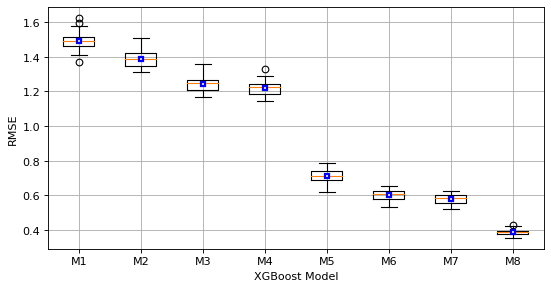

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

sets = [st1, st2, st3, st4, st5, st6, st7, st8]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, len(sets)+1)]
print("Models to be tested: ", sets_names)

### Cross validation through all models defined above
scores_all_models = []
ccc = 0
for set_var in sets:
  ccc+=1
  print("Model M"+str(ccc),":",set_var.columns.values, "   ........" , end = ' ')
  n_repts = 5 #  <---------- SET
  cvr = RepeatedKFold(n_splits = 10, n_repeats = n_repts, random_state=2)
  #modelt = mbp #XGBRegressor() #LogisticRegression()
  scores = cross_val_score(model_best_parm, set_var, y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
  scores_p = [item * -1 for item in scores]
  #print ("Model M"+str(ccc),"   ........ Done !") #print (scores_p)
  print (" Done !") #print (scores_p)
  print ("RMSE:", scores_p)
  scores_all_models.append(scores_p)

### Get mean values of model's scores
from statistics import mean
#mean(scores_all_mods)
row_average = [sum(sub_list) / len(sub_list) for sub_list in scores_all_models]
print ("Mean values of RMSE for each tested model: \n",[round(n, 3) for n in row_average])
print ()

### Plot performance of all the models
fig = plt.figure(figsize=(8, 4), dpi=80)
plt.boxplot(scores_all_models, labels=sets_names, showmeans=1,
            meanprops={"marker":"s","markersize":"4","markerfacecolor":"white",
                       "markeredgecolor":"blue", "markeredgewidth":"2"})

plt.xlabel("XGBoost Model")
plt.ylabel("RMSE")
plt.grid()
plt.show()

fig.savefig('003_sb31_xgb_boxplot_11models.png', dpi=1024)
#files.download("003_sb31_xgb_boxplot_11models.png")

### **6. Validation on new data that was not involved in training/testing**


In [ ]:
from pandas import read_csv
# Read DATA.
#data = read_csv('005_sb31_8v_no_norm_SF0_SFmax_2012_2017_for_train_test.csv', header=0, index_col=0)
#data = read_csv('005_sb59_8v_no_norm_SF0_SFmax.csv', header=0, index_col=0)
data = read_csv('002_sb31_no_norm_2012_2017_for_train_test.csv', header=0, index_col=0)
# From: D:\research\ML_model\new_data
#data = read_csv('002_sb31_no_norm_only_2018_for_val.csv', header=0, index_col=0)
#data = read_csv('004_sb59_no_norm_2006_2011_for_train_test.csv', header=0, index_col=0)
#print (data.head())

### Select predictor and response variables
#X = data.drop(['scenario', 'Tw'],axis=1)                  # SB31   8-predictors
#X = data.drop(['scenario', 'Tw','Wind','HR','pp'],axis=1) # SB31   5-predictors
X = data.drop(['scenario', 'Tw','Wind','HR','pp','SR'],axis=1) # SB31   4-predictors
#X = data.drop(['scenario', 'Tw_59'],axis=1) # For SB 59
y = data['Tw'] # y = data['Tw_59'] #
print ("Data dimension (X), (y):", X.shape, y.shape)

### Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Datasets dimension \n train_x, train_y, test_x, test_y: \n",
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Data dimension (X), (y): (6438, 4) (6438,)
Datasets dimension 
 train_x, train_y, test_x, test_y: 
 (4506, 4) (1932, 4) (4506,) (1932,)


In [ ]:
from xgboost import XGBRegressor

### XGBoost model based on best parameters from mannual tuning
print ("computing ........", str(train_x.shape[1])+ "-p model")
model_best_parm = XGBRegressor(
    alpha = 0.001,# alias "reg_alpha"
    booster = 'gbtree',
    colsample_bytree = 0.9,
    learning_rate = 0.01,
    max_depth = 8,
    n_estimators = 1500,
    objective = 'reg:squarederror',
    subsample = 1,#0.55,
    min_child_weight= 5, #1,
    gamma= 0.1, #0,
    seed=1
    )

### Fit the model and evaluation using train ans test
eval_set = [(train_x, train_y), (test_x, test_y)]
model_best_parm.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

### Prediction on train and test
pred_train = model_best_parm.predict(train_x) # prediction for 'Train' values
predict_test = model_best_parm.predict(test_x)

### RMSE and R2 on train and test using the model with best parameters
from sklearn.metrics import mean_squared_error, r2_score  ## use function score   RMSE

print("Train","RMSE: %.4f" % (mean_squared_error(train_y, model_best_parm.predict(train_x))**(1/2.0)),end=' ')
print("    Train","R2: %.4f" % (model_best_parm.score(train_x, train_y))) # R2

print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, model_best_parm.predict(test_x))**(1/2.0)),end=' ')
print("     Test", "R2: %.4f" % (model_best_parm.score(test_x, test_y)))   # R2
print ()

computing ........ 4-p model
Train RMSE: 0.3586     Train R2: 0.9924
Test RMSE: 0.6579      Test R2: 0.9751



In [ ]:
# Read new data for validation (one year data - the last available data)
#data_one_year = read_csv('005_sb31_8v_no_norm_SF0_SFmax_only_2018_for_validation.csv', header=0, index_col=0)
#data_one_year = read_csv('005_sb59_8v_no_norm_SF0_SFmax_one_year_for_validation.csv', header=0, index_col=0)
data_one_year = read_csv('002_sb31_no_norm_only_2018_for_val.csv', header=0, index_col=0)   # Folder: E:\OSU_PC_D_drive\research\ML_model\new_data
data_one_year.head()

### Select Predictor (X_1yr) and response (X_1yr) variables
#X_1yr = data_one_year[['Ta','Wind','SR','HR','DY','Flow','pp','current_SF']] # 8p model
#X_1yr = data_one_year[['Ta','SR','DY','Flow','current_SF']]                  # 5p model
X_1yr = data_one_year[['Ta','DY','Flow','current_SF']]                        # 4-p model
X_1yr = X_1yr.rename({'current_SF': 'SF'}, axis=1) # Rename

y_1yr = data_one_year['Tw_Hnow'] # y = data['Tw']
y_1yr = y_1yr.rename({'Tw_Hnow': 'Tw'}, axis=1)  # new method
print ("Data dimension (X), (y):", X_1yr.shape, y_1yr.shape)
#print (y_1yr)


Data dimension (X), (y): (365, 4) (365,)


In [ ]:
X_1yr_zero_SF = data_one_year[['Ta','DY','Flow','zero_SF']] # zero_SF
X_1yr_zero_SF = X_1yr_zero_SF.rename({'zero_SF': 'SF'}, axis=1) # Rename
pred_1y_no_ripveg = model_best_parm.predict(X_1yr_zero_SF)


X_1yr_max_SF = data_one_year[['Ta','DY','Flow','max_SF']]   # max_SF
X_1yr_max_SF = X_1yr_max_SF.rename({'max_SF': 'SF'}, axis=1) # Rename
pred_1y_full_ripveg = model_best_parm.predict(X_1yr_max_SF)


Predictors: ['Ta' 'DY' 'Flow' 'SF']    Response: [Tw]
X and y Dimension:  (365, 4) (365,)
RMSE: 1.05775
R2: 0.93143


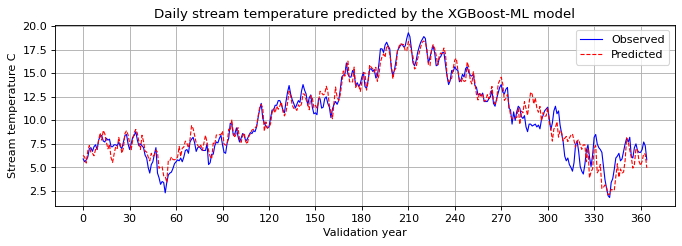

In [ ]:
import numpy as np
### Prediction on new data (validation)
pred_1y = model_best_parm.predict(X_1yr)
#print (pred_1yr)
print ("Predictors:", X_1yr.columns.values, "   Response:",'[Tw]') # print predictor variable names
print ("X and y Dimension: ", X_1yr.shape, y_1yr.shape) # print dimension of variables

### RMSE and R2 on new data (validation)
from sklearn.metrics import mean_squared_error, r2_score  ## use function score   RMSE
print("RMSE: %.5f" % (mean_squared_error(y_1yr, pred_1y)**(1/2.0)))
print("R2: %.5f" % (model_best_parm.score(X_1yr,y_1yr))) # R2

### Plot Time Series of Observed and Predicted data (Validation)
### (One year of records not involved in model training/testing)
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
x_ax = range(len(y_1yr)) #range(len(test_y))

fig = plt.figure(figsize=(10, 3), dpi=80)
#plt.scatter(x_ax, ty, s=5, color="blue", label="Observed")
plt.plot(x_ax, y_1yr, lw=1.0, color="blue", label="Observed")
plt.plot(x_ax, pred_1y, lw=1.0, color="red", label="Predicted", linestyle='--')

plt.title("Daily stream temperature predicted by the XGBoost-ML model")
plt.xlabel("Validation year")
plt.ylabel("Stream temperature C")
plt.legend()
#plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xticks(np.arange(0, 365+1, 30.0))
plt.grid()
plt.show()

#fig.savefig('004_sb31_xgb_time_series_plot.png', dpi=1024)
#files.download("004_sb31_xgb_time_series_plot.png")

Observed Stream-temperature
[5.9, 5.6, 5.8, 6.1, 7.0, 7.1, 6.7, 7.2, 7.4, 6.9, 7.9, 8.3, 8.4, 7.8, 7.7, 8.1, 7.9, 8.0, 7.2, 7.2, 7.4, 7.4, 7.3, 7.7, 7.2, 7.0, 7.7, 8.4, 8.5, 7.5, 6.9, 7.5, 8.2, 8.4, 8.8, 7.9, 7.3, 7.5, 7.3, 7.1, 6.3, 6.0, 5.0, 4.4, 5.3, 5.6, 6.4, 7.1, 4.4, 3.9, 3.2, 3.5, 3.4, 2.3, 3.4, 4.2, 4.4, 4.5, 4.9, 5.4, 5.6, 5.8, 5.7, 6.0, 5.6, 6.1, 6.8, 6.9, 6.5, 7.7, 8.0, 8.2, 7.6, 6.7, 7.1, 7.2, 7.0, 6.8, 6.8, 6.8, 7.5, 5.3, 5.5, 6.4, 6.4, 7.3, 7.7, 7.6, 8.1, 8.4, 7.4, 6.6, 6.5, 7.6, 8.1, 9.7, 9.6, 8.4, 8.6, 9.2, 8.3, 7.7, 8.1, 8.6, 8.4, 7.8, 8.0, 8.4, 8.7, 8.6, 8.9, 8.8, 9.3, 10.3, 11.2, 11.8, 10.2, 9.7, 9.4, 9.2, 9.3, 10.2, 11.1, 11.1, 11.6, 11.6, 12.1, 12.1, 11.7, 11.1, 10.8, 12.0, 13.0, 13.7, 12.8, 12.2, 11.8, 11.3, 11.7, 12.1, 11.9, 13.1, 13.8, 13.2, 12.8, 11.6, 12.4, 12.7, 11.4, 10.7, 10.8, 10.6, 12.3, 12.3, 11.3, 11.4, 12.3, 12.5, 11.8, 11.4, 10.3, 11.2, 11.7, 12.0, 11.7, 12.1, 13.2, 14.6, 14.8, 14.9, 16.1, 14.9, 14.6, 14.6, 15.3, 15.0, 13.7, 14.0, 13.6, 13.9, 14.6, 15

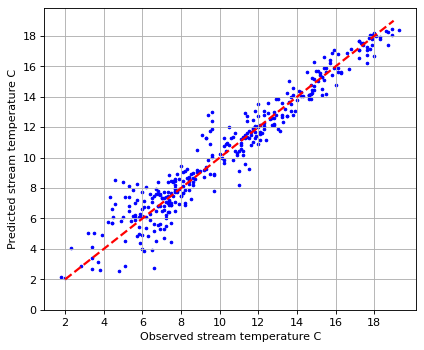

In [ ]:
### Plot scater plot Observed vs Predicted
print ("Observed Stream-temperature")
print (y_1yr.tolist()) #
print ("Predicted Stream-temperature")
print ([round(n, 2) for n in pred_1y.tolist()])
avg_obs = sum(y_1yr.tolist())/len(y_1yr.tolist())
avg_pred = sum(pred_1y.tolist())/len(pred_1y.tolist())

print ("Avge-Obs-str-temp:", round(avg_obs, 3),"       Avge-Pred-str-temp:", round(avg_pred, 3))
print ("done....")

fig = plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(y_1yr, pred_1y, s=5, color="blue", label="Observed")
plt.plot([2, 19], [2, 19],  color='red', linestyle='--', linewidth=2)
plt.xticks(np.arange(2, 18+1, 2))
plt.yticks(np.arange(0, 18+1, 2))
plt.xlabel("Observed stream temperature C")
plt.ylabel("Predicted stream temperature C")
plt.grid()
plt.show()

fig.savefig('005_sb31_xgb_obs_vs_pred.png', dpi=1024)
#files.download("005_sb31_xgb_obs_vs_pred.png")

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Colab_Notebooks/aXGBoost_with_manual_tuned_parms_SB31_submit_2.ipynb

### **Plot Performance**

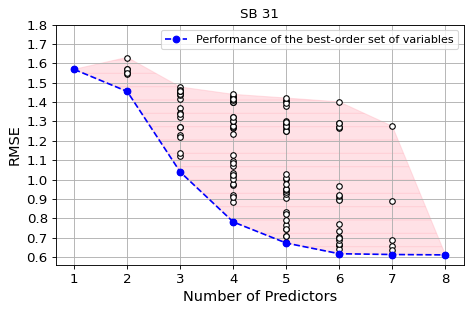

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1, sharex=True, dpi=80)
ym1 = [1.569]
ym2 = [1.556,1.544,1.455,1.63,1.569,1.57,1.551]
ym3 = [1.271,1.039,1.371,1.343,1.325,1.338,1.121,1.456,1.416,1.44,1.438,1.232,1.272,1.135,1.222
       ,1.444,1.478,1.46,1.459,1.465,1.455]
ym4 = [0.781,1.268,1.236,1.276,1.271,0.783,0.918,0.885,0.912,1.279,1.324,1.305,1.303,1.301,1.325
       ,0.971,0.976,1.018,1.003,1.4,1.421,1.401,1.408,1.399,1.411,1.034,1.07,1.025,1.096,1.126
       ,1.088,1.433,1.425,1.44,1.415]
ym5 = [0.677,0.672,0.709,0.746,1.251,1.284,1.272,1.258,1.25,1.286,0.708,0.766,0.745,0.791,0.832
       ,0.823,1.289,1.279,1.305,1.296,0.903,0.953,0.924,0.937,0.945,0.952,1.404,1.381,1.408,1.398
       ,1.001,0.979,1.007,1.03,1.421]
ym6 = [0.617,0.664,0.661,0.643,0.669,0.688,1.269,1.264,1.29,1.273,0.704,0.699,0.732,0.773,1.294
       ,0.9,0.894,0.915,0.919,1.401,0.969]
ym7 = [0.613,0.614,0.655,0.638,1.275,0.688,0.889]
ym8 = [0.611]

yy = [ym1,ym2,ym3,ym4,ym5,ym6,ym7,ym8]
cc1 = 0
for yp in yy:
  xp = [cc1+1] * len(yp) # xm1 = [1] * len(ym1)
  cc1 +=1
  plt.plot(xp, yp, marker="o", markersize=5, markeredgecolor="black", markerfacecolor="white", linestyle="")

#plt.plot(xm1, ym1, marker="o", markersize=5, markeredgecolor="black", markerfacecolor="white", linestyle="")
#plt.plot(xm2, ym2, marker="o", markersize=5, markeredgecolor="black", markerfacecolor="white", linestyle="")

x = np.array([1,2,3,4,5,6,7,8])
y1 = np.array([1.569,1.631,1.478,1.440, 1.421,1.401,1.275,0.611]) # Worst
y2 = np.array([1.569,1.455,1.039,0.781, 0.672,0.617,0.613,0.611]) # Best
y_fi = np.array([1.569,1.545,1.121,0.781, 0.673,0.616,0.611,0.610]) # importance of variables

#line1, = ax1.plot(x, y1, 'o--', color='red') # worst efficient
line2, = ax1.plot(x, y2, 'o--', color='blue') # most efficient
#line3, = ax1.plot(x, y_fi, 'o--', color='black', label='labeldsds2') # importance of variable path
ax1.fill_between(x, y1, y2, color = 'lightpink', alpha = 0.4, hatch = '-')

plt.yticks(np.arange(0.6, 1.8, 0.1))
tx1 = 'Performance of the worst-order set of variables'
tx2 = 'Performance of the best-order set of variables'
tx3 = 'Performance of the set of variables by importance'
#ax1.legend([line1, line2, line3], [tx1, tx2, tx3])
#ax1.legend([line2], [tx2])

ax1.set_title('SB 31')
plt.xlabel("Number of Predictors", fontsize=13)
plt.ylabel("RMSE", fontsize=13)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.grid()
fig.tight_layout()
